In [ ]:
import main
import warnings
import itertools
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")
from prophet import Prophet
from tqdm import tqdm
from datetime import datetime, timedelta
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


PARTE 3

In [ ]:
data = pd.read_csv('Tetuan City power consumption.csv')
data = data.drop(columns=['Temperature','Humidity',	'Wind Speed', 'general diffuse flows', 'diffuse flows', 'Zone 2  Power Consumption', 'Zone 3  Power Consumption'], axis=1)
data['DateTime'] = data['DateTime'].apply(lambda x: x.split()[0])
lista_dias = data['DateTime'].unique().tolist()
df = pd.DataFrame(columns=['DateTime','Zone 1 Power Consumption'])
for i in lista_dias:
    maior = data[data['DateTime'] == i]['Zone 1 Power Consumption'].max()
    df.loc[len(df)] = [i,maior]
data = df.copy()
data.index = pd.date_range(start='2017-01-01', end='2017-12-30', freq='D')
data.drop(columns='DateTime', axis=1, inplace=True)

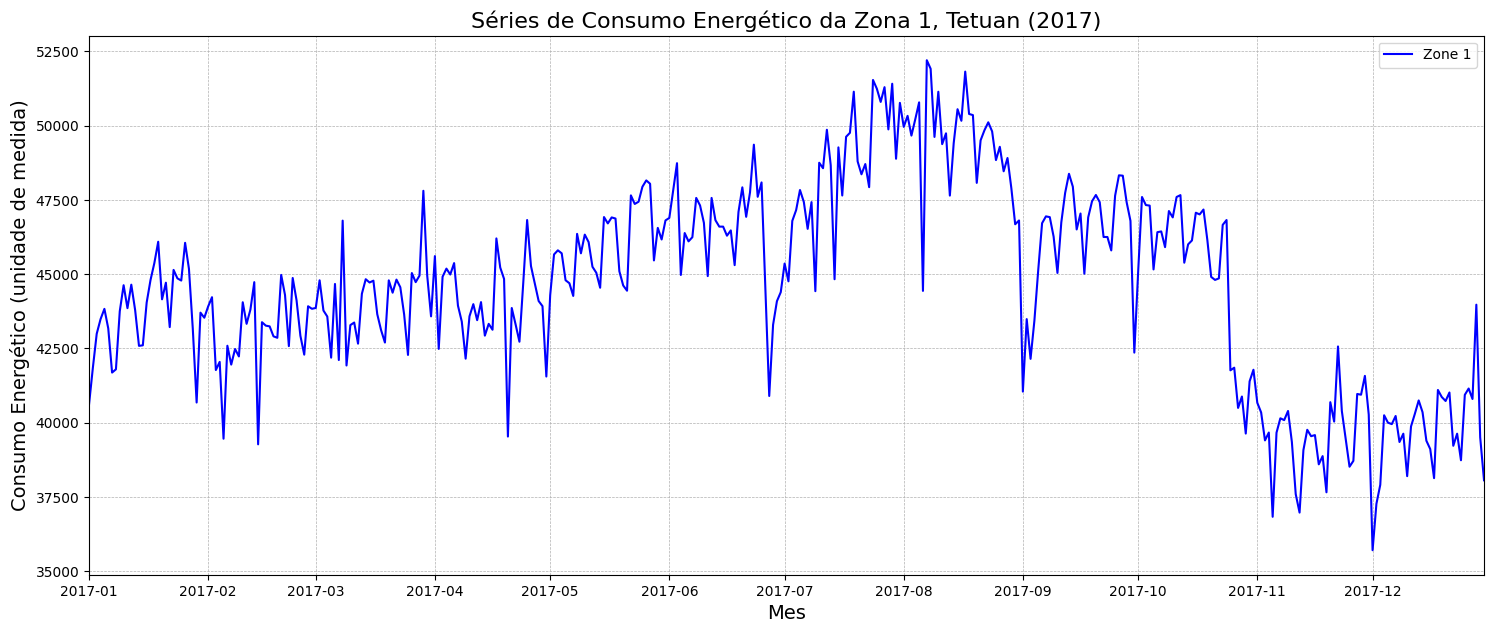

In [ ]:
plt.figure(figsize=(18, 7))
plt.plot(data['Zone 1 Power Consumption'],color='blue',label='Zone 1')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-12-30'))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.legend()
plt.show()

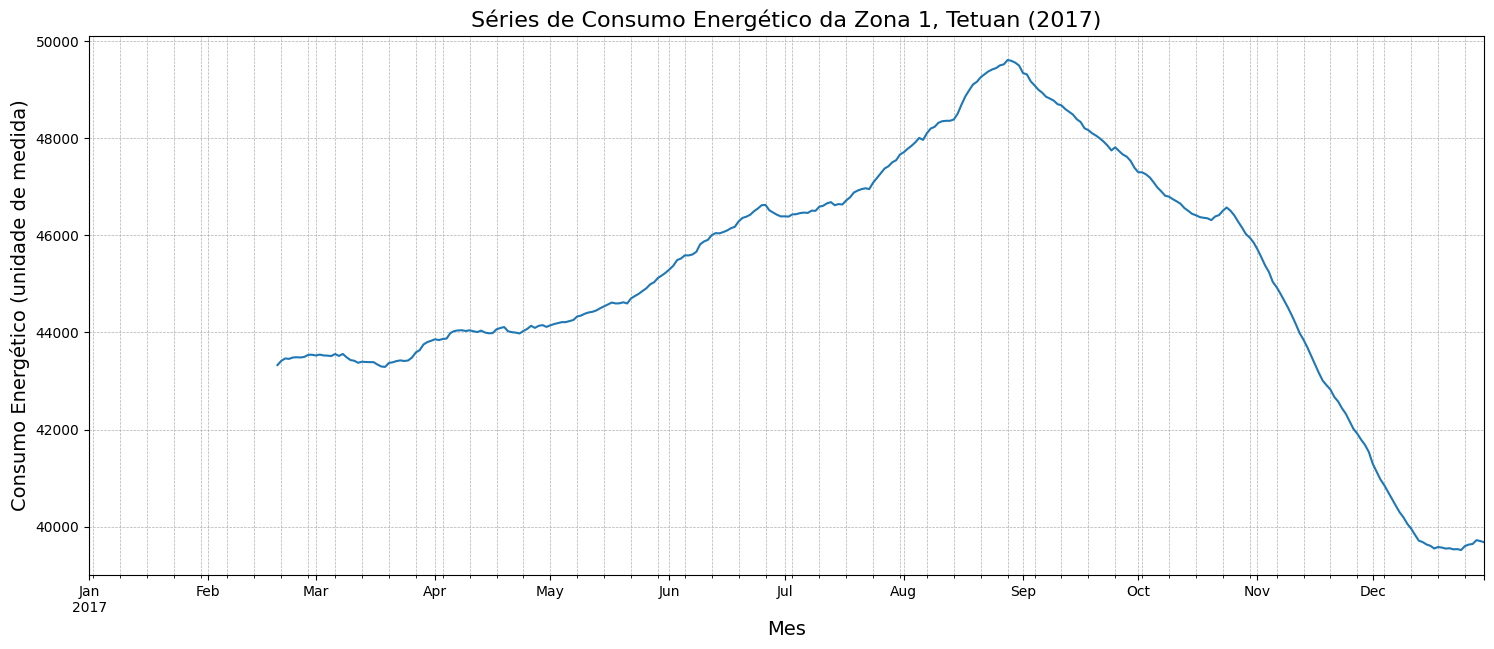

In [ ]:
data['Zone 1 Power Consumption'].rolling(50).mean().plot(figsize=(18, 7))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.show()


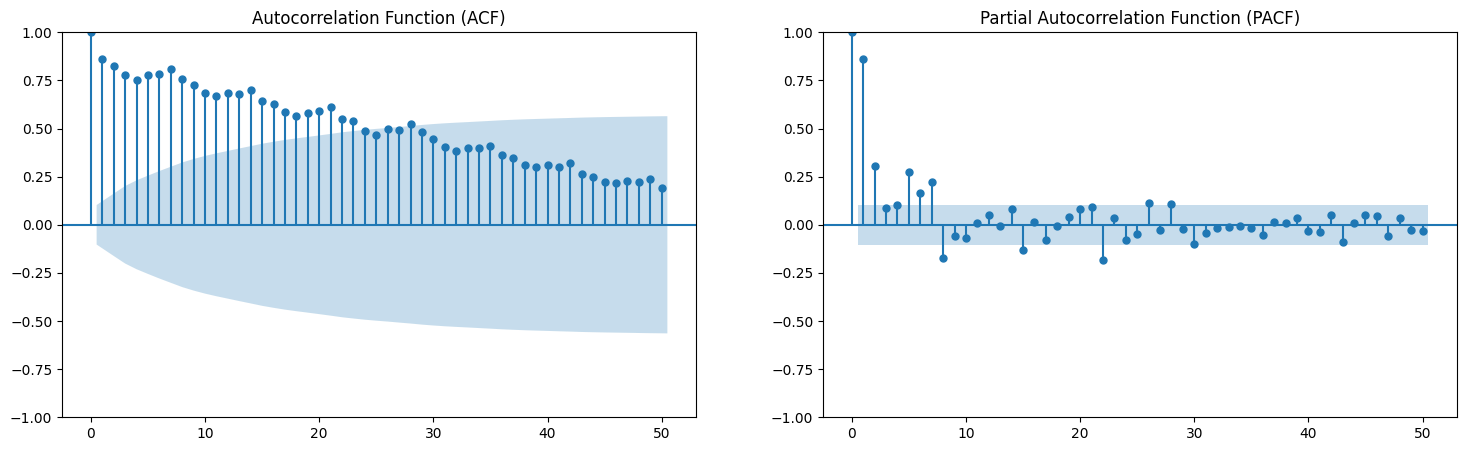

In [ ]:
main.data2_acf_pacf(data['Zone 1 Power Consumption'])

In [ ]:
def print_adfuller_results(data, zone_name):
    result = adfuller(data[zone_name].values)
    print(f'\nResults for {zone_name} Power Consumption:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

print_adfuller_results(data, 'Zone 1 Power Consumption')



Results for Zone 1 Power Consumption Power Consumption:
ADF Statistic: -1.222295
p-value: 0.663932
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


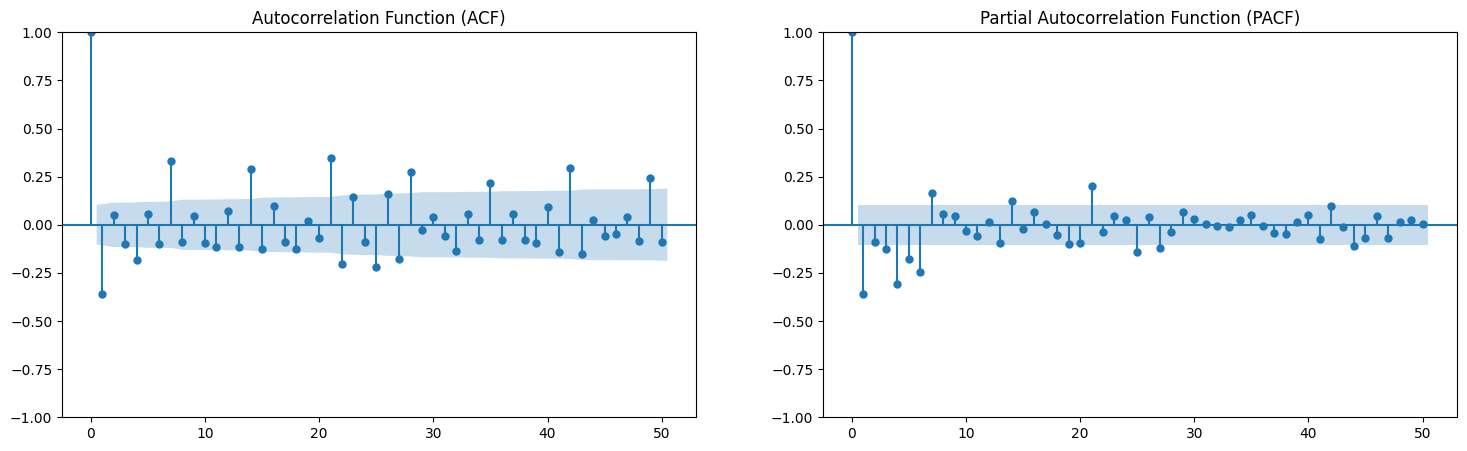


Results for Zone 1 Power Consumption 1 Power Consumption:
ADF Statistic: -9.851981
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [ ]:
df = data.copy()
df['Zone 1 Power Consumption 1']=df['Zone 1 Power Consumption'].diff()
df.dropna(axis=0, inplace = True)
main.data2_acf_pacf(df['Zone 1 Power Consumption 1'])
print_adfuller_results(df, 'Zone 1 Power Consumption 1')

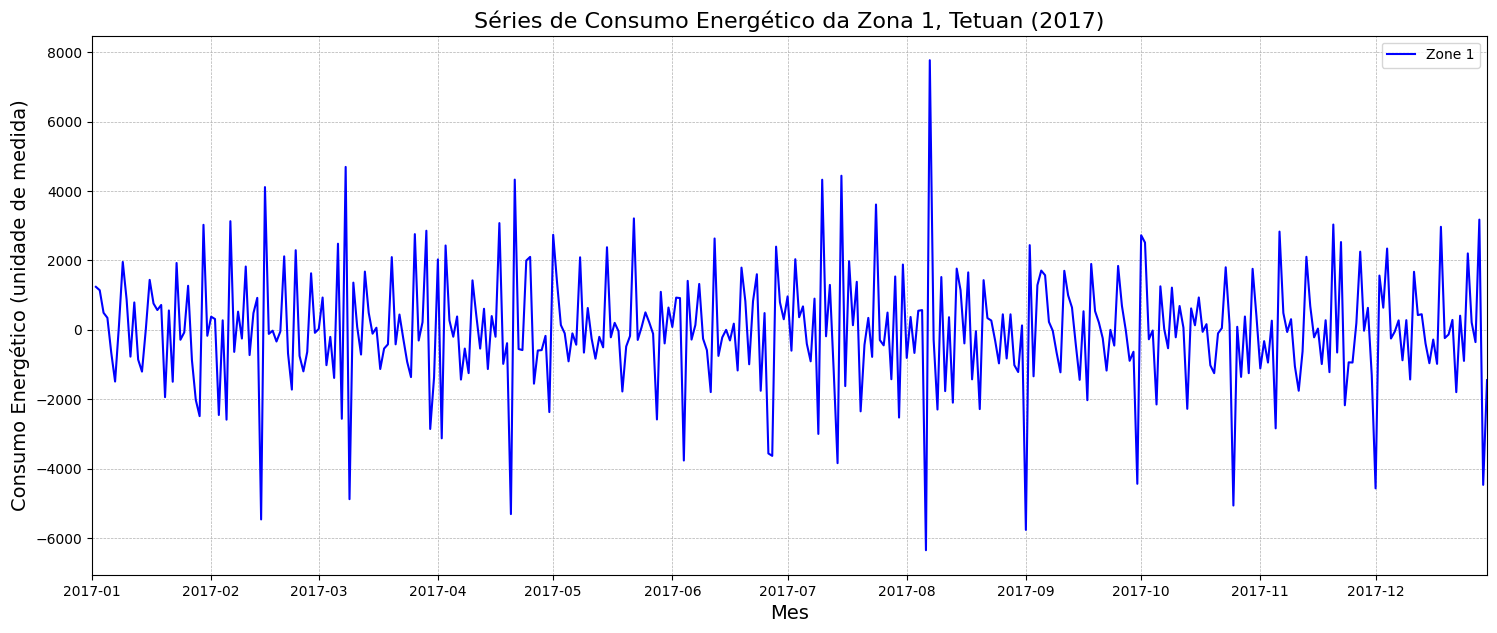

In [ ]:
plt.figure(figsize=(18, 7))
plt.plot(df['Zone 1 Power Consumption 1'],color='blue',label='Zone 1')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-12-30'))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.legend()
plt.show()

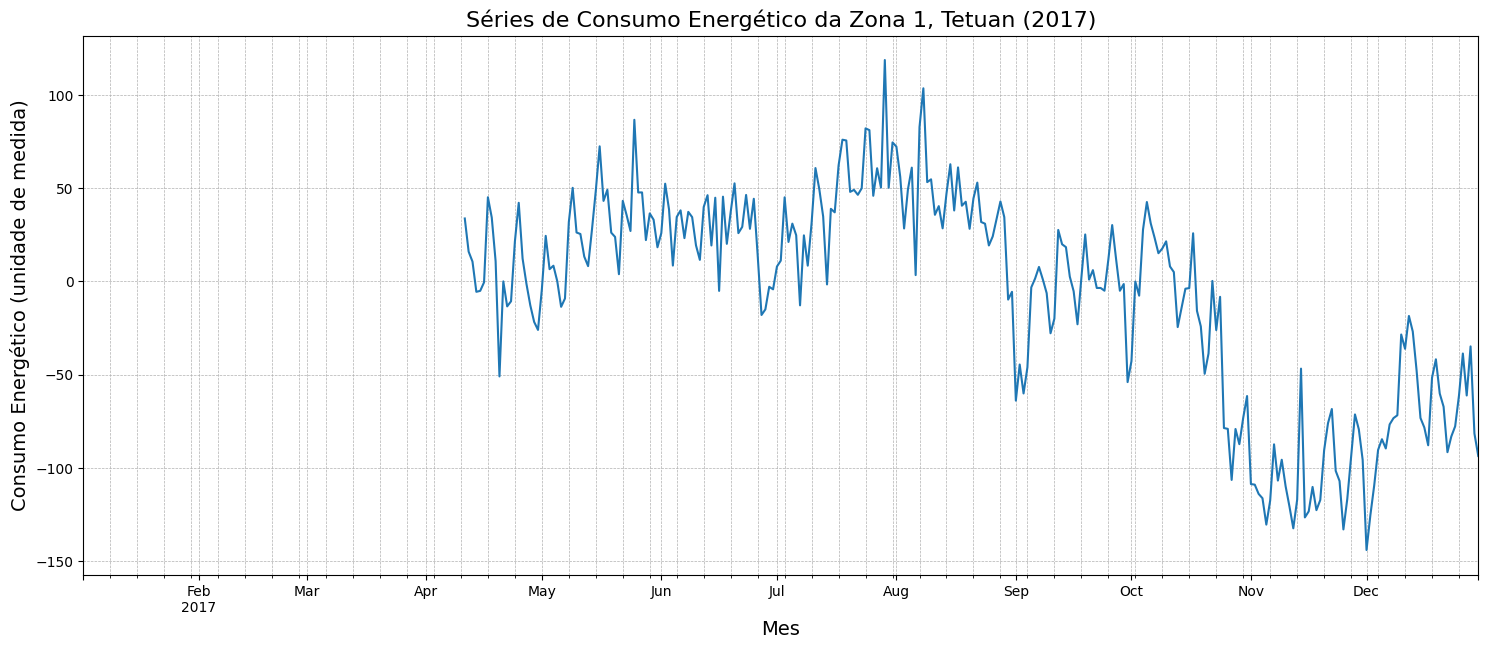

In [ ]:
df['Zone 1 Power Consumption 1'].rolling(100).mean().plot(figsize=(18, 7))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.show()

In [ ]:
threshold = int(0.8*len(data))
train_set = data[:threshold]
test_set = data[threshold:]

In [ ]:
melhor_modelo = None
melhor_mse = float('inf')

# Loop sobre as combinações de parâmetros
for a1, a2, a3 in itertools.product(range(1, 10), range(1, 10), range(1, 4)):
    try:
        sarima = SARIMAX(train_set['Zone 1 Power Consumption'], order=(a1, a2, a3), seasonal_order=(2,1,2,4)).fit()
        mse_atual = (sarima.resid**2).mean()

        # Atualiza o melhor modelo se o MSE atual for menor
        if mse_atual < melhor_mse:
            melhor_mse = mse_atual
            melhor_modelo = sarima

        print(f'MSE: {mse_atual}, AIC: {sarima.aic}, BIC: {sarima.bic}, {a1, a2, a3}')
    except Exception as e:
        print(f'Erro para a combinação {a1, a2, a3}: {e}')

# Imprime as métricas do melhor modelo no final

print("\nMelhor Modelo:")
print(f'MSE: {(melhor_modelo.resid**2).mean()}, AIC: {melhor_modelo.aic}, BIC: {melhor_modelo.bic}, {a1,a2,a3}')


MSE: 11802973.66878742, AIC: 5172.741508550972, BIC: 5198.333451226711, (1, 1, 1)
MSE: 11845639.17648904, AIC: 5176.1691390362075, BIC: 5205.417073522766, (1, 1, 2)
MSE: 11906279.920422286, AIC: 5195.394028729032, BIC: 5228.29795502641, (1, 1, 3)
MSE: 15954651.974490067, AIC: 5196.118284386945, BIC: 5221.685708648825, (1, 2, 1)
MSE: 15922824.218643647, AIC: 5198.747439472316, BIC: 5227.967352914465, (1, 2, 2)
MSE: 16108235.847037656, AIC: 5201.607714722723, BIC: 5234.4801173451415, (1, 2, 3)
MSE: 26710349.091574356, AIC: 5285.957740776594, BIC: 5311.500560443722, (1, 3, 1)
MSE: 31141485.20023176, AIC: 5313.928062286767, BIC: 5343.119856192057, (1, 3, 2)
MSE: 26944997.428979643, AIC: 5348.4580420689, BIC: 5381.298810212351, (1, 3, 3)
MSE: 63239909.626863904, AIC: 5666.111516000863, BIC: 5691.629644284366, (1, 4, 1)
MSE: 50571530.43166598, AIC: 5359.684718965696, BIC: 5388.848294146842, (1, 4, 2)
MSE: 51852333.0288484, AIC: 5627.13765235594, BIC: 5659.946674434729, (1, 4, 3)
MSE: 1497690

In [ ]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suponha que 'train_set' seja seu conjunto de treinamento

# Inicializa as variáveis para armazenar o modelo com o maior erro e seu erro
modelo_maior_erro = None
maior_erro = float('-inf')

# Loop sobre as combinações de parâmetros
for a1, a2 in itertools.product(range(1, 22), range(1, 4)):
    try:
        sarima = SARIMAX(train_set['Zone 1 Power Consumption'], order=(9, 9, 3), seasonal_order=(a1, 1, a2, 10)).fit()
        mse_atual = (sarima.resid**2).mean()

        # Atualiza o modelo com o maior erro se o MSE atual for maior
        if mse_atual > maior_erro:
            maior_erro = mse_atual
            modelo_maior_erro = sarima

        print(f'MSE: {mse_atual}, AIC: {sarima.aic}, BIC: {sarima.bic}, {a1, a2, a3}')
    except Exception as e:
        print(f'Erro para a combinação {a1, a2, a3}: {e}')


print("\nModelo com Maior Erro:")
print(f'MSE: {(modelo_maior_erro.resid**2).mean()}, AIC: {modelo_maior_erro.aic}, BIC: {modelo_maior_erro.bic}, {a1,a2,a3}')

9 9 3 1, 1, 10

MSE: 2212962130.2891684, AIC: 5623.928199537744, BIC: 5699.65004292996, (1, 1, 14)
MSE: 2309034495.211428, AIC: 5621.042432947544, BIC: 5700.370078406056, (1, 2, 14)
MSE: 2440875720.729871, AIC: 5674.4035043371305, BIC: 5757.336951861938, (1, 3, 14)
MSE: 2397630817.1778383, AIC: 5624.973644256276, BIC: 5704.301289714788, (2, 1, 14)
MSE: 2403003052.8273654, AIC: 5623.792679693534, BIC: 5706.726127218342, (2, 2, 14)
MSE: 2506219267.7982492, AIC: 5632.697317369455, BIC: 5719.236566960559, (2, 3, 14)
MSE: 2325647348.329693, AIC: 5618.806487741129, BIC: 5701.739935265937, (3, 1, 14)
MSE: 2297461625.218005, AIC: 5623.081071933846, BIC: 5709.62032152495, (3, 2, 14)
MSE: 2375420727.3443904, AIC: 5626.882866245514, BIC: 5717.027917902914, (3, 3, 14)
MSE: 2221358273.0257134, AIC: 5624.2388142297605, BIC: 5710.778063820864, (4, 1, 14)
MSE: 2397427262.9138656, AIC: 5637.3335494874755, BIC: 5727.478601144875, (4, 2, 14)
MSE: 2354234524.4073734, AIC: 5628.3243116928215, BIC: 5722.075165416518, (4, 3

KeyboardInterrupt: 

In [ ]:
for a1, a2, a3 in itertools.product(range(1, 10), range(1, 10), range(1, 4)):
    try:
        sarima = SARIMAX(train_set['Zone 1 Power Consumption'], order=(a1, a2, a3), seasonal_order=(2,1,2,4)).fit()
        print(f'MSE: {(sarima.resid**2).mean()}, AIC: {sarima.aic}, BIC: {sarima.bic}, {a1,a2,a3}')
    except Exception as e:
        print(f'Erro para a combinação {a1, a2, a3}: {e}')

MSE: 11802973.66878742, AIC: 5172.741508550972, BIC: 5198.333451226711, (1, 1, 1)
MSE: 11845639.17648904, AIC: 5176.1691390362075, BIC: 5205.417073522766, (1, 1, 2)
MSE: 11906279.920422286, AIC: 5195.394028729032, BIC: 5228.29795502641, (1, 1, 3)
MSE: 15954651.974490067, AIC: 5196.118284386945, BIC: 5221.685708648825, (1, 2, 1)
MSE: 15922824.218643647, AIC: 5198.747439472316, BIC: 5227.967352914465, (1, 2, 2)
MSE: 16108235.847037656, AIC: 5201.607714722723, BIC: 5234.4801173451415, (1, 2, 3)
MSE: 26710349.091574356, AIC: 5285.957740776594, BIC: 5311.500560443722, (1, 3, 1)
MSE: 31141485.20023176, AIC: 5313.928062286767, BIC: 5343.119856192057, (1, 3, 2)
MSE: 26944997.428979643, AIC: 5348.4580420689, BIC: 5381.298810212351, (1, 3, 3)
MSE: 63239909.626863904, AIC: 5666.111516000863, BIC: 5691.629644284366, (1, 4, 1)
MSE: 50571530.43166598, AIC: 5359.684718965696, BIC: 5388.848294146842, (1, 4, 2)
MSE: 51852333.0288484, AIC: 5627.13765235594, BIC: 5659.946674434729, (1, 4, 3)
MSE: 1497690

In [ ]:
for a1,a2,a3 in itertools.product(range(1,22),range(1,22),range(1,22)):
    try:
        sarima = SARIMAX(train_set['Zone 1 Power Consumption'], order=(9, 9, 3), seasonal_order=(a1,1,a2,a3)).fit()
        print(f'MSE: {(sarima.resid**2).mean()}, AIC: {sarima.aic}, BIC: {sarima.bic}, {a1}')
    except Exception as e:
        print(f'Erro para a combinação {a1}: {e}')

In [ ]:
sarima_zona_1 = SARIMAX(train_set['Zone 1 Power Consumption'], order=(1, 1, 3), seasonal_order=(1,1,1,10)).fit()
print('MSE:',(sarima_zona_1.resid**2).mean())
print('AIC:',sarima_zona_1.aic)
print('BIC:',sarima_zona_1.bic)

MSE: 11742432.748872006
AIC: 5046.047899489721
BIC: 5071.491426711906


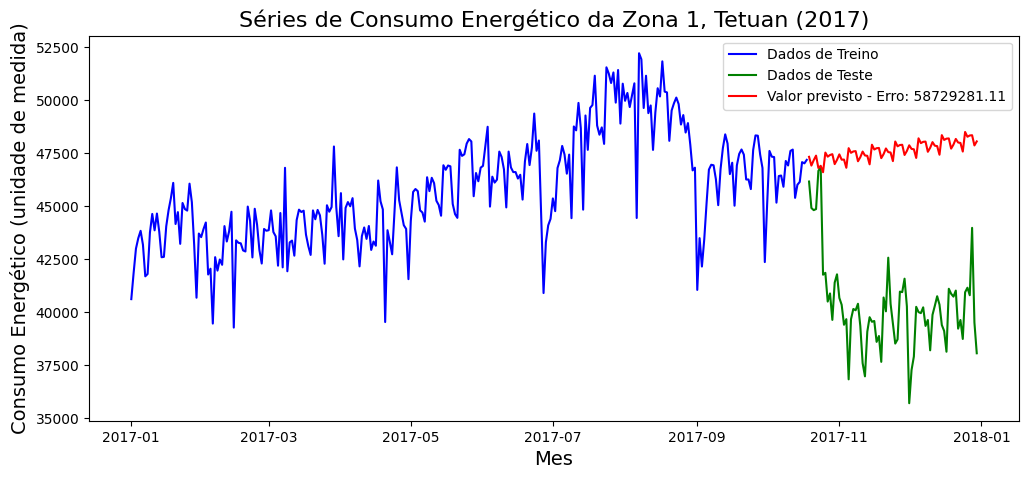

In [ ]:
dados_teste = test_set['Zone 1 Power Consumption']
previsoes = sarima_zona_1.forecast(len(dados_teste))
mse = mean_squared_error(dados_teste, previsoes)

plt.figure(figsize=(12,5))
plt.plot(train_set['Zone 1 Power Consumption'], label='Dados de Treino',color='blue')
plt.plot(test_set['Zone 1 Power Consumption'], label='Dados de Teste',color='green')
plt.plot(sarima_zona_1.forecast(len(test_set['Zone 1 Power Consumption'])), label=f'Valor previsto - Erro: {mse.round(2)}',color='red')
plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.legend()
plt.show()


<h2> Suavização Exponencial Simples</h2>

In [ ]:
n = 10 # número de divisões do intervalo [0, 1]
h = 1/n # amplitude de cada intervalo
alphas = []
alpha = h
errors = []
for i in range(n):
  alphas.append(alpha)
  ses = SimpleExpSmoothing(data['Zone 1 Power Consumption']).fit(smoothing_level=alpha, optimized=False)
  mse = (ses.resid**2).mean()
  errors.append(mse)
  alpha = alpha + h
print('alphas = ',alphas)
print('MSE = ', errors)

alphas =  [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999]
MSE =  [3057623.7162639867, 2500553.7826966154, 2370076.666450779, 2343269.1562061897, 2355138.4919269774, 2390045.1444644197, 2448075.7772797723, 2535417.602464371, 2660945.6482795356, 2835544.4348865896]


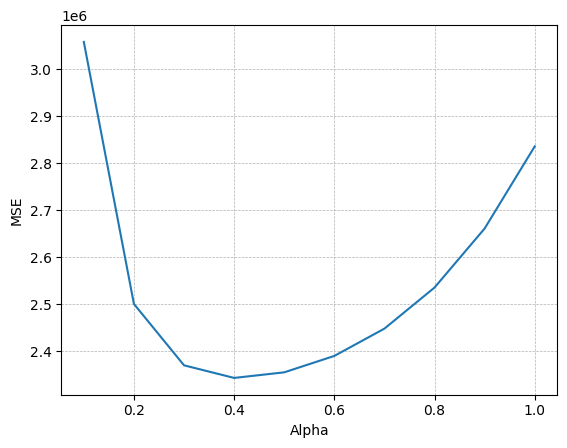

In [ ]:
n = 10 # número de divisões do intervalo [0, 1]
h = 1/n # amplitude de cada intervalo
alphas = []
alpha = h
errors = []
for i in range(n):
  alphas.append(alpha)
  ses = SimpleExpSmoothing(data['Zone 1 Power Consumption']).fit(smoothing_level=alpha, optimized=False)
  mse = (ses.resid**2).mean()
  errors.append(mse)
  alpha = alpha + h
plt.plot(alphas, errors)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
smoot_level = 0.1
menor_mse = float('inf')
melhor_sl = 0
while True:
    if smoot_level >0.95:
        break
    SES = SimpleExpSmoothing(train_set['Zone 1 Power Consumption']).fit(smoothing_level=smoot_level, optimized=False)
    MSE_Treino = ((SES.resid)**2).mean()
    if MSE_Treino < menor_mse:
        menor_mse = MSE_Treino
        melhor_sl = smoot_level

    MSE_Teste = mean_squared_error(test_set['Zone 1 Power Consumption'],SES.forecast(len(test_set)))
    print(f'SMOOTHING LEVEL= {round(smoot_level,2)} MSE TREINO: {round(MSE_Treino,2)} MSE TESTE: {round(MSE_Teste,2)}')
    smoot_level+=0.01

print(f'MENOR MSE TREINO={round(menor_mse,2)} MELHOR SL = {round(melhor_sl,2)}')

SMOOTHING LEVEL= 0.1 MSE TREINO: 2704054.22 MSE TESTE: 45097620.54
SMOOTHING LEVEL= 0.11 MSE TREINO: 2643364.26 MSE TESTE: 45144222.57
SMOOTHING LEVEL= 0.12 MSE TREINO: 2592228.31 MSE TESTE: 45216593.51
SMOOTHING LEVEL= 0.13 MSE TREINO: 2548805.32 MSE TESTE: 45304212.08
SMOOTHING LEVEL= 0.14 MSE TREINO: 2511702.25 MSE TESTE: 45401069.16
SMOOTHING LEVEL= 0.15 MSE TREINO: 2479840.09 MSE TESTE: 45503653.48
SMOOTHING LEVEL= 0.16 MSE TREINO: 2452368.09 MSE TESTE: 45609833.53
SMOOTHING LEVEL= 0.17 MSE TREINO: 2428606.05 MSE TESTE: 45718252.79
SMOOTHING LEVEL= 0.18 MSE TREINO: 2408003.7 MSE TESTE: 45828008.08
SMOOTHING LEVEL= 0.19 MSE TREINO: 2390111.43 MSE TESTE: 45938478.66
SMOOTHING LEVEL= 0.2 MSE TREINO: 2374558.57 MSE TESTE: 46049233.36
SMOOTHING LEVEL= 0.21 MSE TREINO: 2361037.07 MSE TESTE: 46159976.93
SMOOTHING LEVEL= 0.22 MSE TREINO: 2349289.08 MSE TESTE: 46270515.79
SMOOTHING LEVEL= 0.23 MSE TREINO: 2339097.28 MSE TESTE: 46380733.53
SMOOTHING LEVEL= 0.24 MSE TREINO: 2330277.43 MSE TE

In [ ]:
SES_final = SimpleExpSmoothing(train_set['Zone 1 Power Consumption']).fit(smoothing_level=melhor_sl, optimized=False)

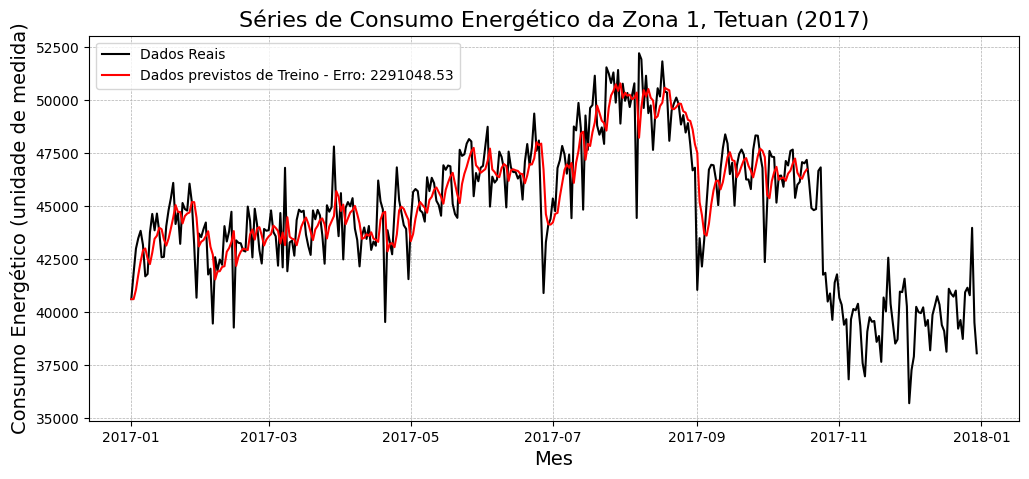

In [ ]:
mse = mean_squared_error(train_set, SES_final.fittedvalues)
plt.figure(figsize=(12,5))
plt.plot(data['Zone 1 Power Consumption'], color='black', label='Dados Reais')
plt.plot(SES_final.fittedvalues, color='red', label=f'Dados previstos de Treino - Erro: {mse.round(2)}')
plt.legend()
plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

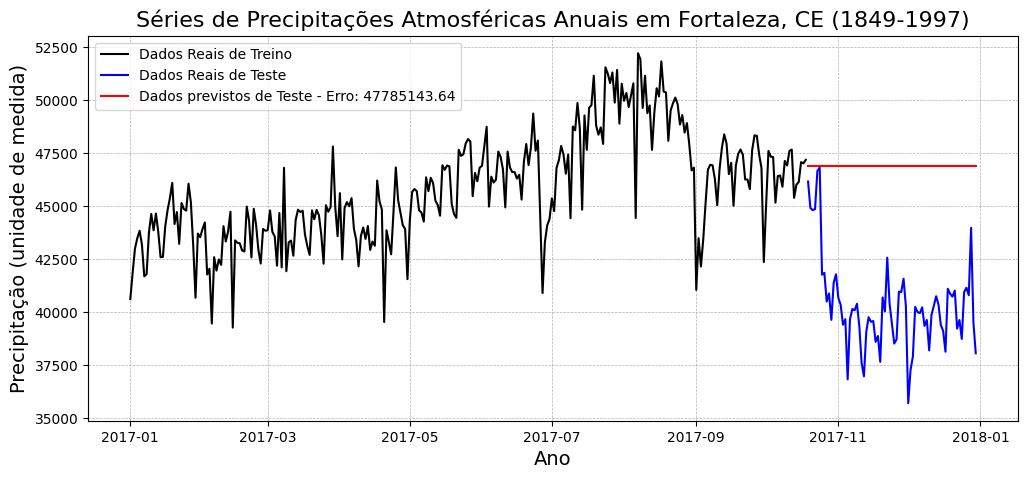

In [ ]:
mse = mean_squared_error(test_set, SES_final.forecast(len(test_set)))
plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais de Treino')
plt.plot(test_set, color='blue', label='Dados Reais de Teste')
plt.plot(SES_final.forecast(len(test_set)), color='red', label=f'Dados previstos de Teste - Erro: {mse.round(2)}')
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

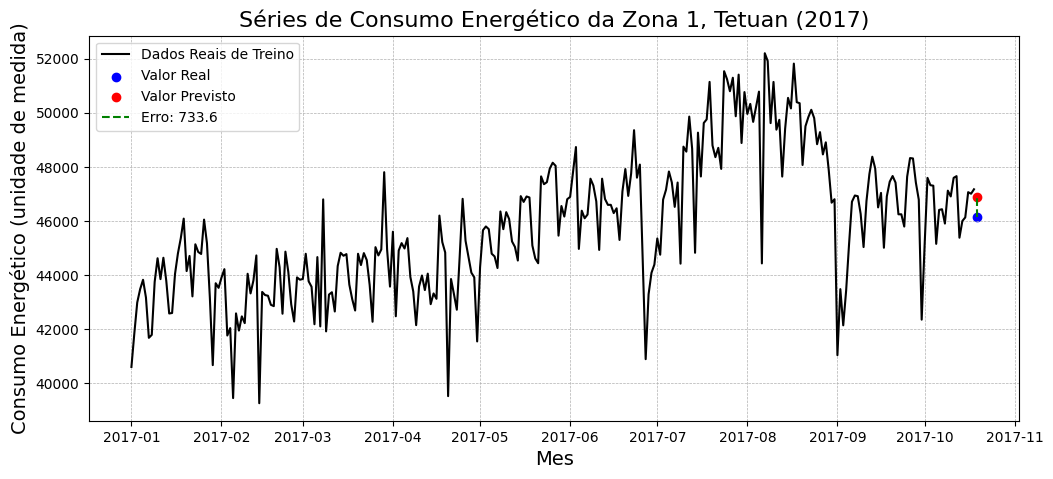

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set['Zone 1 Power Consumption'], color='black', label='Dados Reais de Treino')
plt.scatter(test_set.index[0], test_set['Zone 1 Power Consumption'].iloc[0], color='blue', marker='o', label='Valor Real')
plt.scatter(test_set.index[0], SES_final.forecast(1), color='red', marker='o', label="Valor Previsto")
x_values = [test_set.index[0], test_set.index[0]]
y_values = [test_set['Zone 1 Power Consumption'].iloc[0], SES_final.forecast(1).values[0]]
erro = ((SES_final.forecast(1).values[0] - test_set['Zone 1 Power Consumption'].iloc[0])**2)**(1/2)
plt.plot(x_values, y_values, linestyle='--', color='green', label=f'Erro: {erro.round(2)}')
plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


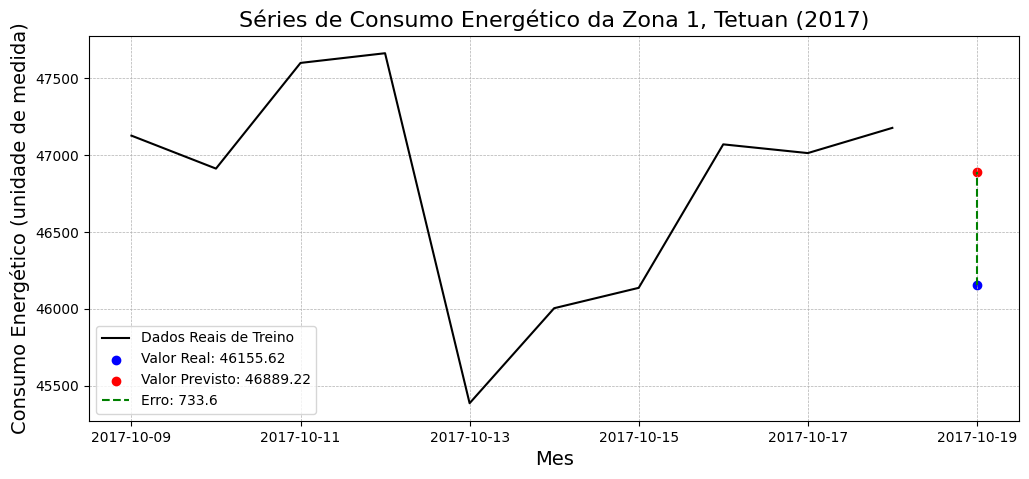

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set['Zone 1 Power Consumption'].tail(10), color='black', label='Dados Reais de Treino')
plt.scatter(test_set.index[0], test_set['Zone 1 Power Consumption'].iloc[0], color='blue', marker='o', label=f'Valor Real: {test_set["Zone 1 Power Consumption"].iloc[0].round(2)}')
plt.scatter(test_set.index[0], SES_final.forecast(1), color='red', marker='o', label=f"Valor Previsto: {SES_final.forecast(1)[0].round(2)}")
x_values = [test_set.index[0], test_set.index[0]]
y_values = [test_set['Zone 1 Power Consumption'].iloc[0], SES_final.forecast(1).values[0]]
erro = ((SES_final.forecast(1).values[0] - test_set['Zone 1 Power Consumption'].iloc[0])**2)**(1/2)
plt.plot(x_values, y_values, linestyle='--', color='green', label=f'Erro: {erro.round(2)}')

plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

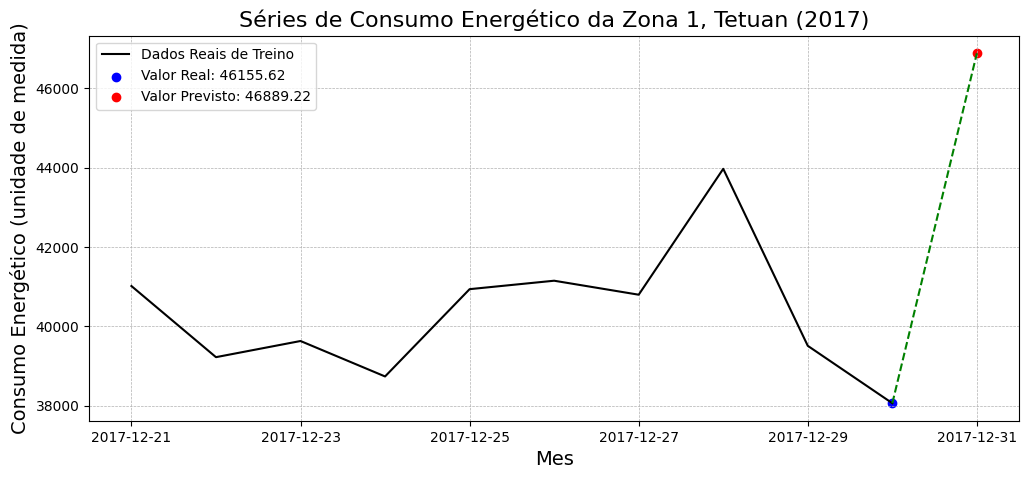

In [ ]:
data_string = "2017/12/31"
formato_string = "%Y/%m/%d"
data_datetime = datetime.strptime(data_string, formato_string)

plt.figure(figsize=(12,5))
plt.plot(data['Zone 1 Power Consumption'].tail(10), color='black', label='Dados Reais de Treino')
plt.scatter(data['Zone 1 Power Consumption'].index[-1], data['Zone 1 Power Consumption'].iloc[-1], color='blue', marker='o', label=f'Valor Real: {test_set["Zone 1 Power Consumption"].iloc[0].round(2)}')
plt.scatter(data_datetime, SES_final.forecast(1), color='red', marker='o', label=f"Valor Previsto: {SES_final.forecast(1)[0].round(2)}")

plt.plot([data['Zone 1 Power Consumption'].index[-1], data_datetime], [data['Zone 1 Power Consumption'].iloc[-1], SES_final.forecast(1).values[0]], linestyle='--', color='green')



plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

<h4> Suavização Exponencial de Holt otimizada (com optimized = True) </h4>

In [ ]:
SEH_opt = Holt(train_set["Zone 1 Power Consumption"]).fit(optimized=True)

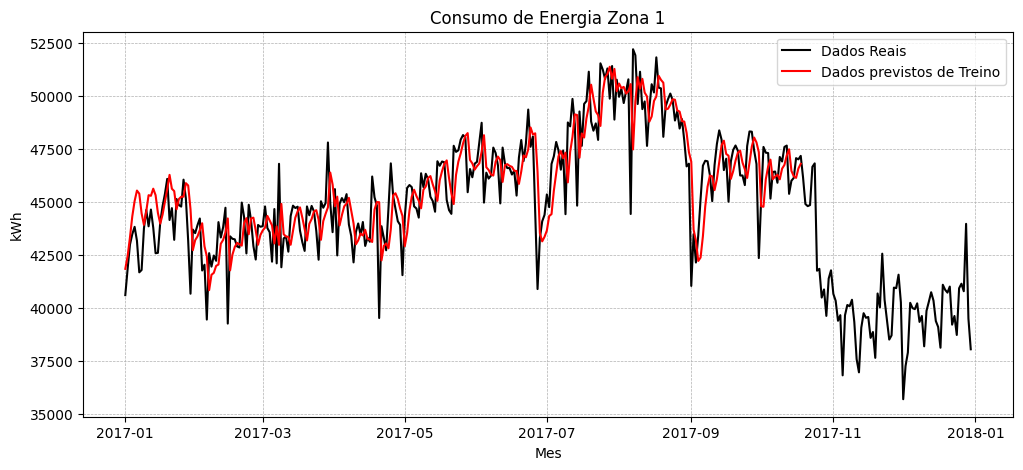

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(data["Zone 1 Power Consumption"], color='black', label='Dados Reais')
plt.plot(SEH_opt.fittedvalues, color='red', label='Dados previstos de Treino')
plt.title('Consumo de Energia Zona 1')
plt.xlabel('Mes')
plt.ylabel('kWh')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

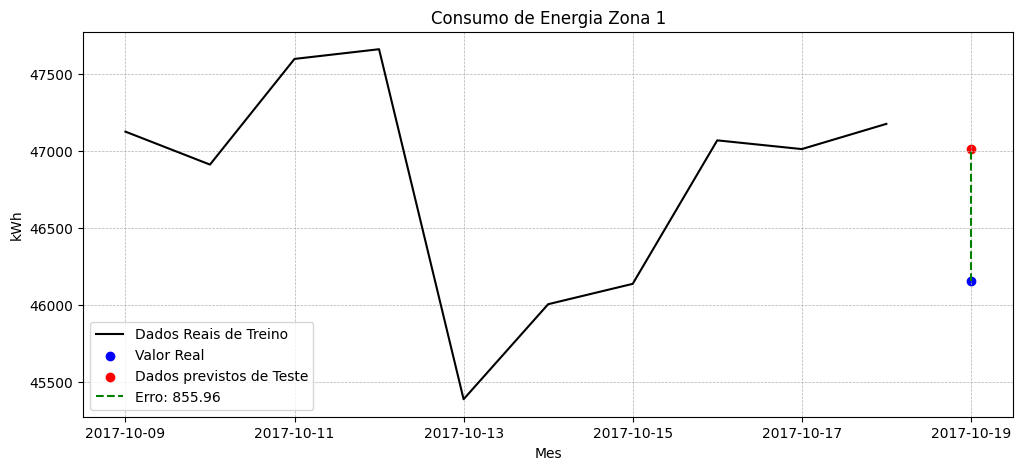

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set['Zone 1 Power Consumption'].tail(10), color='black', label='Dados Reais de Treino')
plt.scatter(test_set.index[0], test_set['Zone 1 Power Consumption'].iloc[0], color='blue', marker='o', label='Valor Real')
plt.scatter(test_set.index[0], SEH_opt.forecast(1), color='red', label='Dados previstos de Teste')

x_values = [test_set.index[0], test_set.index[0]]
y_values = [test_set['Zone 1 Power Consumption'].iloc[0], SEH_opt.forecast(1).values[0]]

erro = ((SEH_opt.forecast(1).values[0] - test_set['Zone 1 Power Consumption'].iloc[0])**2)**(1/2)
plt.plot(x_values, y_values, linestyle='--', color='green', label=f'Erro: {erro.round(2)}')
plt.title('Consumo de Energia Zona 1')
plt.xlabel('Mes')
plt.ylabel('kWh')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

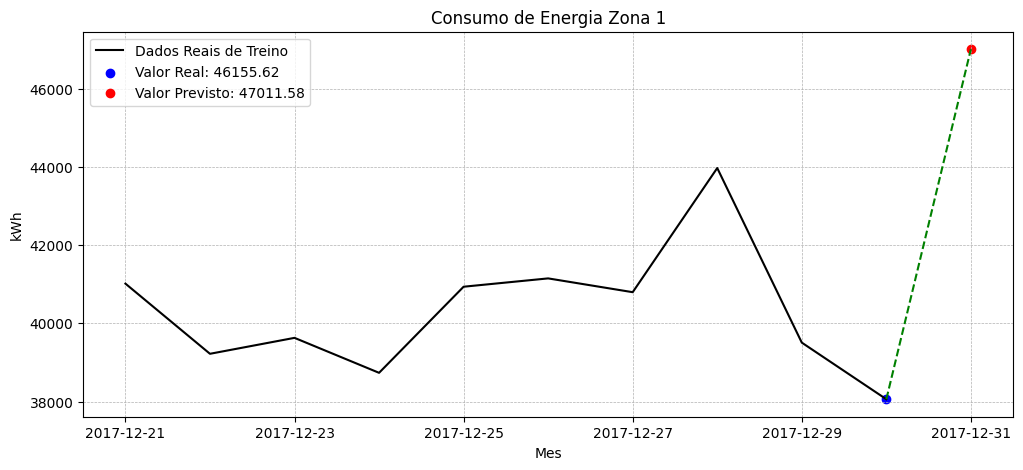

In [ ]:
data_string = "2017/12/31"
formato_string = "%Y/%m/%d"
data_datetime = datetime.strptime(data_string, formato_string)

plt.figure(figsize=(12,5))
plt.plot(data['Zone 1 Power Consumption'].tail(10), color='black', label='Dados Reais de Treino')
plt.scatter(data['Zone 1 Power Consumption'].index[-1], data['Zone 1 Power Consumption'].iloc[-1], color='blue', marker='o', label=f'Valor Real: {test_set["Zone 1 Power Consumption"].iloc[0].round(2)}')
plt.scatter(data_datetime, SEH_opt.forecast(1), color='red', marker='o', label=f"Valor Previsto: {SEH_opt.forecast(1)[0].round(2)}")

plt.plot([data['Zone 1 Power Consumption'].index[-1], data_datetime], [data['Zone 1 Power Consumption'].iloc[-1], SEH_opt.forecast(1).values[0]], linestyle='--', color='green')



plt.title('Consumo de Energia Zona 1')
plt.xlabel('Mes')
plt.ylabel('kWh')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

<h2> Árvore de decisão</h2>

In [ ]:
#vamos manter os valores de profundidade da arvore e valores de shift relativamente baixos para evitar overfitting
menor_mse = float('inf')
melhor_p = 0
melhor_depth = 0
for p in range(1,31):
    print('VALOR P ', p)
    data1_tree = data.copy()
    for i in range(p):
        data1_tree[f'X_{i+1}'] = data1_tree['Zone 1 Power Consumption'].shift(i+1)
    data1_tree.dropna(axis=0, inplace=True)
    x = data1_tree.drop('Zone 1 Power Consumption', axis=1)
    y = data1_tree['Zone 1 Power Consumption']
    for depth in range(1,6):
        print('VALOR DEPTH ', depth)
        model = DecisionTreeRegressor(max_depth=depth) # Com poda (prune)
        threshold = int(0.8*len(data1_tree))
        x_train = x[:threshold]
        x_test = x[threshold:]
        y_train = y[:threshold]
        y_test = y[threshold:]
        model.fit(x_train,y_train)
        MSE_Treino = mean_squared_error(y_train,model.predict(x_train))
        if MSE_Treino < menor_mse:
            menor_mse = MSE_Treino
            melhor_p = p
            melhor_depth = depth
        MSE_Teste = mean_squared_error(model.predict(x_test),y_test.values)
        print(f'P = {p} DEPTJ = {depth} MSE TREINO: {round(MSE_Treino,2)} MSE TESTE: {round(MSE_Teste,2)}')

print(f'MENOR MSE TREINO={round(menor_mse,2)} MELHOR P = {melhor_p} MELHOR PROFUNDIDADE = {melhor_depth}')



VALOR P  1
VALOR DEPTH  1
P = 1 DEPTJ = 1 MSE TREINO: 3396446.95 MSE TESTE: 22678533.92
VALOR DEPTH  2
P = 1 DEPTJ = 2 MSE TREINO: 2371802.05 MSE TESTE: 14494418.21
VALOR DEPTH  3
P = 1 DEPTJ = 3 MSE TREINO: 2205719.57 MSE TESTE: 10457237.3
VALOR DEPTH  4
P = 1 DEPTJ = 4 MSE TREINO: 1913220.74 MSE TESTE: 11703752.02
VALOR DEPTH  5
P = 1 DEPTJ = 5 MSE TREINO: 1547531.84 MSE TESTE: 13247109.19
VALOR P  2
VALOR DEPTH  1
P = 2 DEPTJ = 1 MSE TREINO: 3382451.66 MSE TESTE: 22800836.63
VALOR DEPTH  2
P = 2 DEPTJ = 2 MSE TREINO: 2370363.57 MSE TESTE: 14627525.69
VALOR DEPTH  3
P = 2 DEPTJ = 3 MSE TREINO: 2055927.08 MSE TESTE: 10785670.25
VALOR DEPTH  4
P = 2 DEPTJ = 4 MSE TREINO: 1779280.53 MSE TESTE: 12335668.39
VALOR DEPTH  5
P = 2 DEPTJ = 5 MSE TREINO: 1512301.63 MSE TESTE: 14471150.3
VALOR P  3
VALOR DEPTH  1
P = 3 DEPTJ = 1 MSE TREINO: 3385342.08 MSE TESTE: 22872995.54
VALOR DEPTH  2
P = 3 DEPTJ = 2 MSE TREINO: 2377579.83 MSE TESTE: 14671282.02
VALOR DEPTH  3
P = 3 DEPTJ = 3 MSE TREINO: 20

In [ ]:
data3_tree = data.copy()
p = melhor_p
for i in range(p):
  data3_tree[f'X_{i+1}'] = data3_tree['Zone 1 Power Consumption'].shift(i+1)
data3_tree.dropna(axis=0, inplace=True)
x = data3_tree.drop('Zone 1 Power Consumption', axis=1)
y = data3_tree['Zone 1 Power Consumption']
threshold = int(0.8*len(data3_tree))
x_train = x[:threshold]
x_test = x[threshold:]
y_train = y[:threshold]
y_test = y[threshold:]

In [ ]:
tree_final = DecisionTreeRegressor(max_depth=melhor_depth)
tree_final.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=5)

In [ ]:
y_test

2017-10-23    46659.78118
2017-10-24    46823.63239
2017-10-25    41763.15098
2017-10-26    41851.37856
2017-10-27    40496.45514
                 ...     
2017-12-26    41149.80989
2017-12-27    40796.95817
2017-12-28    43972.62357
2017-12-29    39507.22433
2017-12-30    38059.31559
Freq: D, Name: Zone 1 Power Consumption, Length: 69, dtype: float64

In [ ]:
fitted = tree_final.predict(x_train)
fitted

array([43668.4634164 , 43363.676182  , 44997.25381   , 45353.91380061,
       45353.91380061, 45353.91380061, 45353.91380061, 44207.10087364,
       42333.71541   , 43668.4634164 , 43668.4634164 , 43668.4634164 ,
       43668.4634164 , 42333.71541   , 42333.71541   , 39459.66102   ,
       43782.21670048, 42333.71541   , 43668.4634164 , 42333.71541   ,
       43782.21670048, 43782.21670048, 44301.68049   , 43782.21670048,
       39401.540565  , 43668.4634164 , 43668.4634164 , 43668.4634164 ,
       43668.4634164 , 42333.71541   , 44997.25381   , 44207.10087364,
       43363.676182  , 44997.25381   , 43363.676182  , 43668.4634164 ,
       43668.4634164 , 43668.4634164 , 43668.4634164 , 43668.4634164 ,
       44301.68049   , 44207.10087364, 43668.4634164 , 43668.4634164 ,
       43668.4634164 , 43363.676182  , 43668.4634164 , 43363.676182  ,
       43782.21670048, 43668.4634164 , 42333.71541   , 43782.21670048,
       45353.91380061, 43363.676182  , 45353.91380061, 43363.676182  ,
      

In [ ]:
dates = pd.date_range(start=y_train.index[0], periods=len(fitted), freq='D')
fitted_dates = pd.Series(fitted, index=dates, name='Valores')
fitted_dates

2017-01-21    43668.463416
2017-01-22    43363.676182
2017-01-23    44997.253810
2017-01-24    45353.913801
2017-01-25    45353.913801
                  ...     
2017-10-18    47291.761482
2017-10-19    47291.761482
2017-10-20    45353.913801
2017-10-21    45353.913801
2017-10-22    46485.835097
Freq: D, Name: Valores, Length: 275, dtype: float64

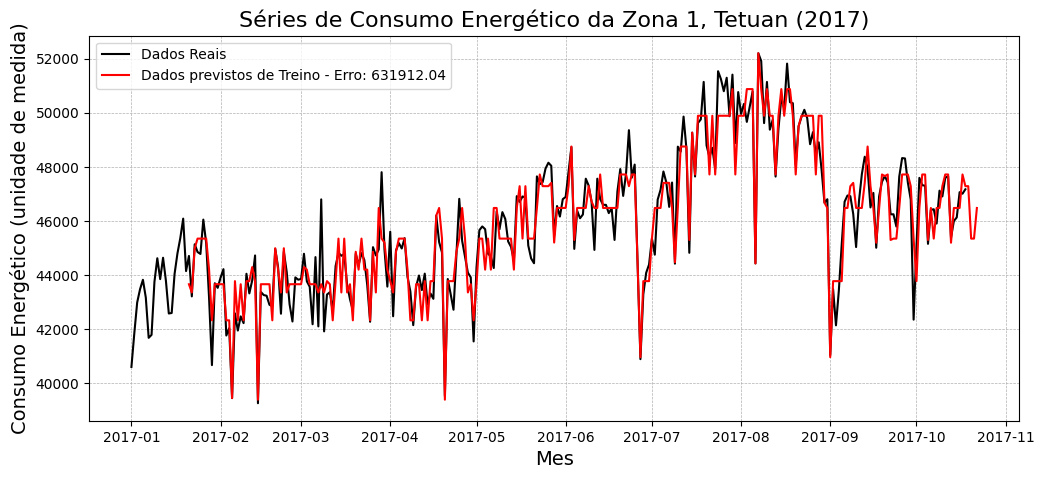

In [ ]:
mse = mean_squared_error(fitted,data[data.index.isin(fitted_dates.index.tolist())]['Zone 1 Power Consumption'].tolist())

plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais')
plt.plot(fitted_dates, color='red', label=f'Dados previstos de Treino - Erro: {mse.round(2)}')
plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


In [ ]:
forecast= tree_final.predict(x_test)
forecast

array([46485.83509711, 46485.83509711, 46485.83509711, 43782.21670048,
       43782.21670048, 43782.21670048, 43782.21670048, 43782.21670048,
       43782.21670048, 43782.21670048, 43782.21670048, 39459.66102   ,
       39459.66102   , 39459.66102   , 43782.21670048, 43782.21670048,
       44301.68049   , 39459.66102   , 39459.66102   , 46204.00431   ,
       44997.25381   , 44997.25381   , 44997.25381   , 44997.25381   ,
       44997.25381   , 44997.25381   , 44997.25381   , 44997.25381   ,
       44997.25381   , 44997.25381   , 44997.25381   , 44997.25381   ,
       44997.25381   , 44997.25381   , 44997.25381   , 44997.25381   ,
       44997.25381   , 44997.25381   , 44997.25381   , 44997.25381   ,
       44997.25381   , 44997.25381   , 44997.25381   , 44997.25381   ,
       44997.25381   , 44997.25381   , 43668.4634164 , 44997.25381   ,
       44997.25381   , 44997.25381   , 44997.25381   , 44997.25381   ,
       44997.25381   , 44997.25381   , 44997.25381   , 44997.25381   ,
      

In [ ]:
dates = pd.date_range(start=y_test.index[0], periods=len(forecast), freq='D')
forecast_dates = pd.Series(forecast, index=dates, name='Valores')
forecast_dates

2017-10-23    46485.835097
2017-10-24    46485.835097
2017-10-25    46485.835097
2017-10-26    43782.216700
2017-10-27    43782.216700
                  ...     
2017-12-26    44997.253810
2017-12-27    44997.253810
2017-12-28    44997.253810
2017-12-29    44997.253810
2017-12-30    44997.253810
Freq: D, Name: Valores, Length: 69, dtype: float64

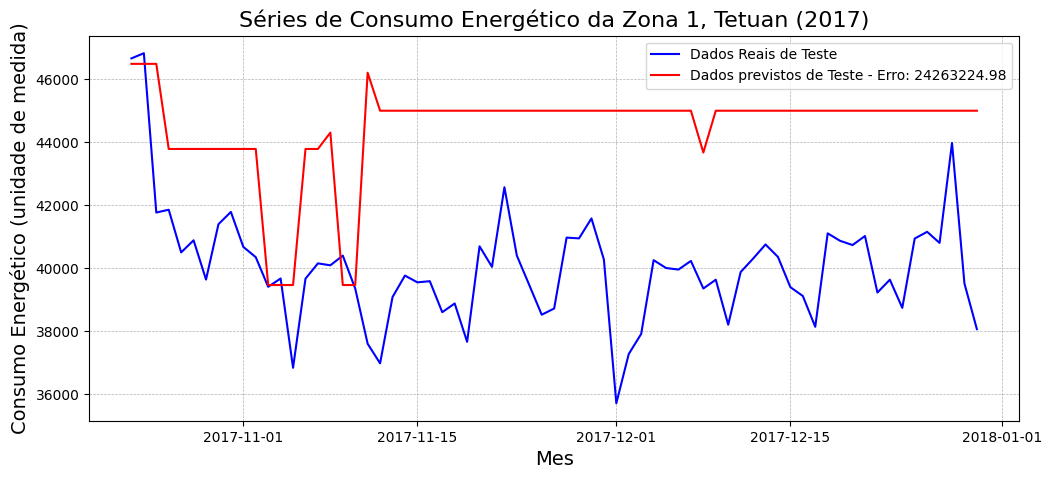

In [ ]:
mse = mean_squared_error(forecast_dates,data[data.index.isin(forecast_dates.index.tolist())]['Zone 1 Power Consumption'].tolist())
plt.figure(figsize=(12,5))
plt.plot(y_test, color='blue', label='Dados Reais de Teste')
plt.plot(forecast_dates, color='red', label=f'Dados previstos de Teste - Erro: {mse.round(2)}')
plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

<h2> Suavização Exponencial de Holt-Winter</h2>

In [ ]:
has_zero = (data == 0).any().any()
has_zero

False

In [ ]:
epsilon = 1e-9
data2_corrigido = data + epsilon

In [ ]:
threshold = int(0.8*len(data2_corrigido))
train_set = data2_corrigido[:threshold]
test_set = data2_corrigido[threshold:]

In [ ]:
# sesonal periods precisa começar com pelo menos 2
#como estamos fazendo treino-teste, o valor máximo de seasonal periods é 59
season = 2
menor_mse = float('inf')
melhor_sp = 0
trend = ['add','mul']
seasonal = ['add','mul']
melhor_trend = ''
melhor_seasonal = ''
for t in trend:
    print(t)
    for s in seasonal:
        print(s)
        for i in range(2,40):
            SE = ExponentialSmoothing(train_set, seasonal_periods=i, trend=t, seasonal=s).fit()
            MSE_Treino = ((SE.resid)**2).mean()
            if MSE_Treino < menor_mse:
                menor_mse = MSE_Treino
                melhor_sp = i
                melhor_trend = t
                melhor_seasonal = s

            MSE_Teste = mean_squared_error(test_set,SE.forecast(len(test_set)))
            print(f'SEASONAL PERIOD= {i} MSE TREINO: {round(MSE_Treino,2)} MSE TESTE: {round(MSE_Teste,2)}')

print(f'MENOR MSE TREINO={round(menor_mse,2)} MELHOR SP = {round(melhor_sp,2)} MELHOR TREND = {melhor_trend} MELHOR SEASONAL = {melhor_seasonal}')


add
add
SEASONAL PERIOD= 2 MSE TREINO: 2338683.81 MSE TESTE: 45095238.54
SEASONAL PERIOD= 3 MSE TREINO: 2372851.15 MSE TESTE: 45355146.51
SEASONAL PERIOD= 4 MSE TREINO: 2410524.08 MSE TESTE: 44226644.91
SEASONAL PERIOD= 5 MSE TREINO: 2391804.8 MSE TESTE: 44183205.81
SEASONAL PERIOD= 6 MSE TREINO: 2399459.82 MSE TESTE: 45655062.21
SEASONAL PERIOD= 7 MSE TREINO: 1821627.58 MSE TESTE: 38082917.1
SEASONAL PERIOD= 8 MSE TREINO: 2413959.0 MSE TESTE: 42731978.68
SEASONAL PERIOD= 9 MSE TREINO: 2486090.04 MSE TESTE: 45759215.2
SEASONAL PERIOD= 10 MSE TREINO: 2517075.91 MSE TESTE: 44082482.16
SEASONAL PERIOD= 11 MSE TREINO: 2436251.67 MSE TESTE: 46644505.59
SEASONAL PERIOD= 12 MSE TREINO: 2351237.83 MSE TESTE: 44347430.11
SEASONAL PERIOD= 13 MSE TREINO: 2428358.61 MSE TESTE: 39956329.62
SEASONAL PERIOD= 14 MSE TREINO: 1837167.33 MSE TESTE: 40722148.88
SEASONAL PERIOD= 15 MSE TREINO: 2384264.35 MSE TESTE: 49021804.35
SEASONAL PERIOD= 16 MSE TREINO: 2444646.86 MSE TESTE: 47296168.69
SEASONAL PERIO

In [ ]:
SE_final = ExponentialSmoothing(train_set, seasonal_periods=melhor_sp, trend=melhor_trend, seasonal=melhor_seasonal).fit()

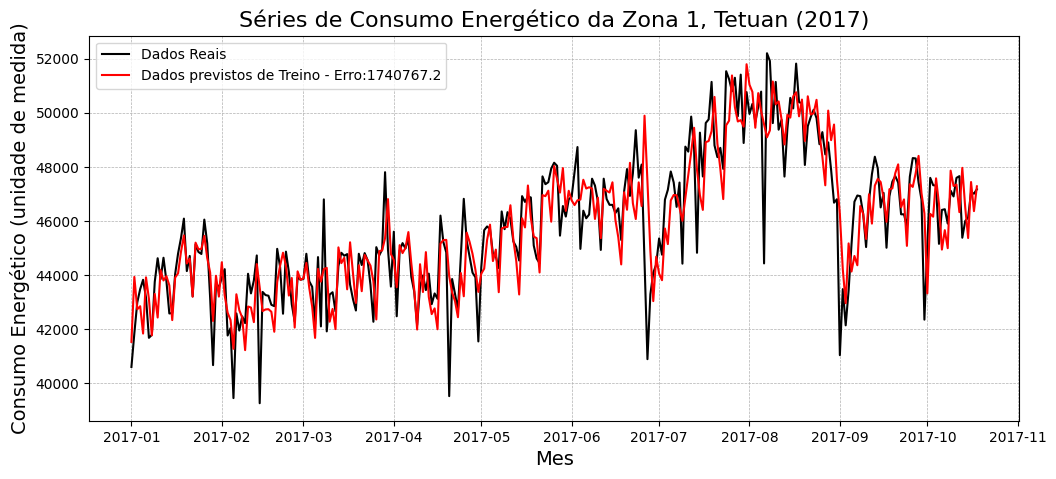

In [ ]:
mse = mean_squared_error(train_set, SE_final.fittedvalues)

plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais')
plt.plot(SE_final.fittedvalues, color='red', label=f'Dados previstos de Treino - Erro:{mse.round(2)}')
plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

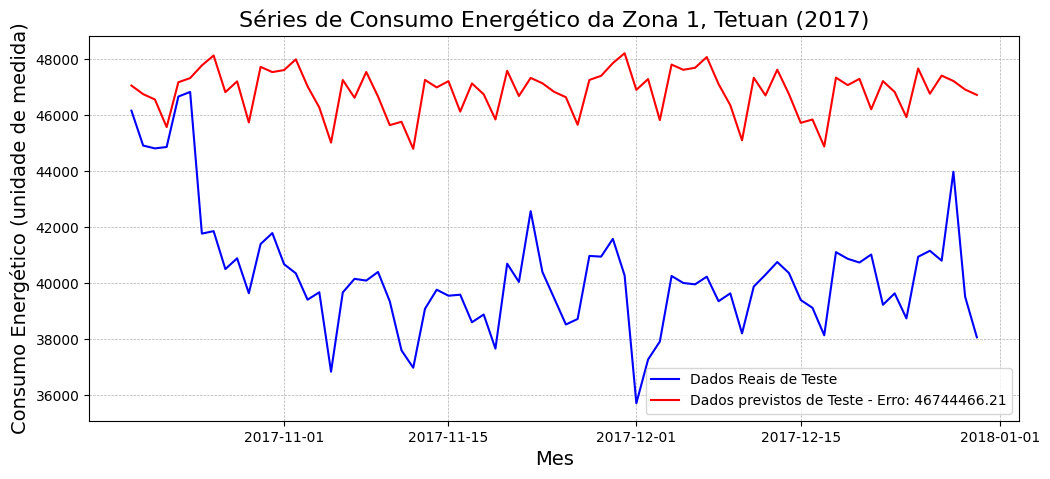

In [ ]:
mse = mean_squared_error(test_set,SE_final.forecast(len(test_set)))

plt.figure(figsize=(12,5))
#plt.plot(train_set, color='black', label='Dados Reais de Treino')
plt.plot(test_set, color='blue', label='Dados Reais de Teste')
plt.plot(SE_final.forecast(len(test_set)), color='red', label=f'Dados previstos de Teste - Erro: {mse.round(2)}')
plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
data.tail()

,Zone 1 Power Consumption
2017-12-26,41149.80989
2017-12-27,40796.95817
2017-12-28,43972.62357
2017-12-29,39507.22433
2017-12-30,38059.31559


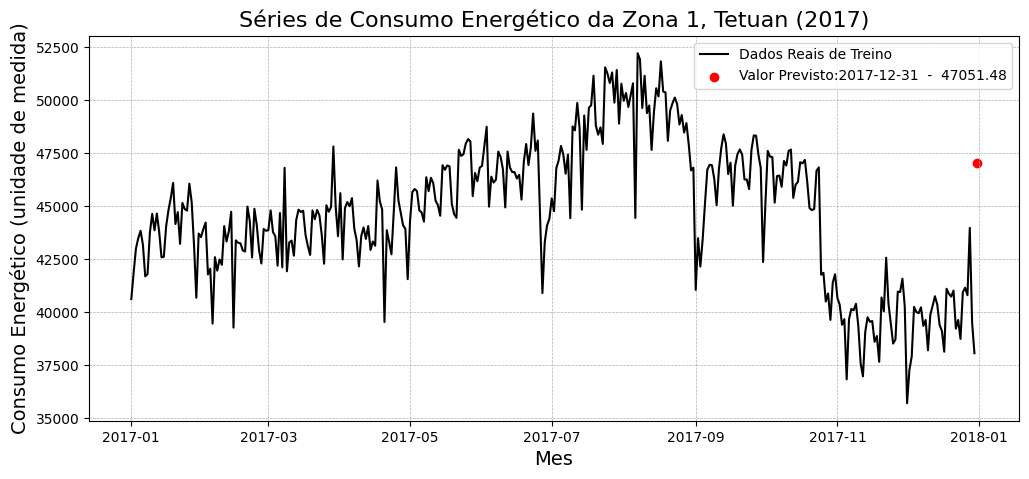

In [ ]:
forecast_index = pd.Timestamp('2017-12-31')


plt.figure(figsize=(12,5))
plt.plot(data['Zone 1 Power Consumption'], color='black', label='Dados Reais de Treino')

plt.scatter(forecast_index, SE_final.forecast(1), color='red', marker='o', label=f'Valor Previsto:{str(forecast_index).split()[0]}  -  {SE_final.forecast(1)[0].round(2)}')

plt.title('Séries de Consumo Energético da Zona 1, Tetuan (2017)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Consumo Energético (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()